## Setup and get data

In [1]:
COMPETITION_NAME = 'digit-recognizer' # replace me

# Kaggle competition bootstrapping
!pip install -qq fastai
!pip install -qq kaggle

from fastai.imports import *
np.set_printoptions(linewidth=130)

# get competition data
iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')

if iskaggle:
    path = Path('../input/'+COMPETITION_NAME)
else:
    DOWNLOADS = Path('downloads')
    import zipfile,kaggle
    path = DOWNLOADS / COMPETITION_NAME
    if not path.is_dir():
        kaggle.api.competition_download_cli(COMPETITION_NAME, path=DOWNLOADS)
        zipfile.ZipFile(f'{path}.zip').extractall(path)
print('done')

done


In [2]:
!ls {path}

models	sample_submission.csv  test  test.csv  train  train.csv


## Data preprocessing
Moving csv format to images in folders

In [3]:
df = pd.read_csv(path/'train.csv')
df.label.value_counts()

1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: label, dtype: int64

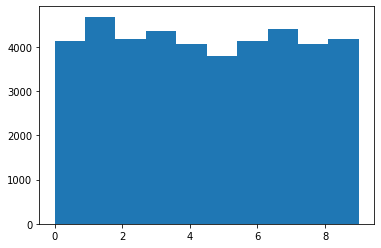

In [4]:
import matplotlib.pyplot as plt
import numpy as np
plt.hist(df.label)
plt.show()

In [5]:
test_df = pd.read_csv(path/"test.csv")
len(test_df)

28000

In [7]:
#create folders 
TRAIN_IMGS = path / 'train'
TEST_IMGS = path / 'test'
if not TRAIN_IMGS.exists():
    print('creating', TRAIN_IMGS)
    TRAIN_IMGS.mkdir()
if not TEST_IMGS.exists():
    print('creating', TEST_IMGS)
    TEST_IMGS.mkdir()
for i in range(10):
    pi = TRAIN_IMGS/(str(i))
    if not pi.exists():
        print('creating', pi)
        pi.mkdir()
print('done')

done


In [8]:
from PIL import Image

def saveMNIST(digit, filepath):
    digit = digit.reshape(28,28)
    digit = digit.astype(np.uint8)

    img = Image.fromarray(digit)
    img.save(filepath)

# training set
for index, row in df.iterrows():
    label,digit = row[0], row[1:]
    folder = TRAIN_IMGS/str(label)
    filename = f"{index}.jpg"
    filepath = folder/filename
    if filepath.exists(): continue
    
    digit = digit.values
    
    saveMNIST(digit, filepath)

# test set
for index, digit in test_df.iterrows():
    filename = f"{index}.jpg"
    filepath = TEST_IMGS/filename
    if filepath.exists(): continue
    
    digit = digit.values
    
    saveMNIST(digit, filepath)


## Let's create a friggin model

In [8]:
!pip install -q timm

import timm 
from fastai.vision.all import *

files = get_image_files(TRAIN_IMGS)
len(files)

42000

In [67]:
dls = ImageDataLoaders.from_folder(TRAIN_IMGS, valid_pct=0.2,
    item_tfms=None,
    batch_tfms=aug_transforms(size=32, min_scale=0.75, do_flip=False)
    )
print(len(dls.train), len(dls.valid))

525 132


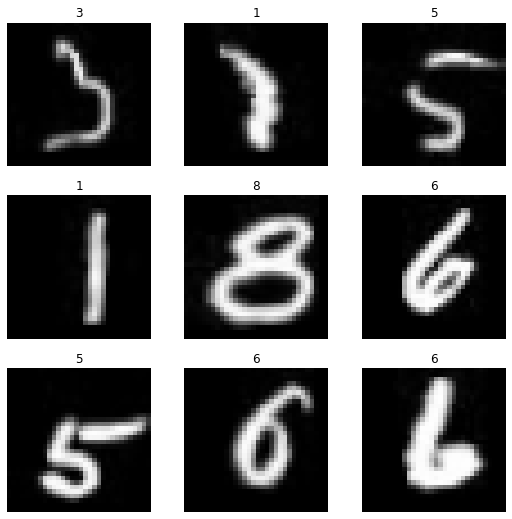

In [68]:
dls.show_batch()

In [69]:
learn = vision_learner(dls, 'convnext_large_in22k', metrics=error_rate)
#learn = vision_learner(dls, 'convnext_base_in22ft1k', metrics=error_rate)

In [70]:
learn.fine_tune(15)

epoch,train_loss,valid_loss,error_rate,time
0,0.227103,0.125920,0.040238,00:25


epoch,train_loss,valid_loss,error_rate,time
0,0.084873,0.040476,0.013095,01:05
1,0.056810,0.033933,0.010833,01:07
2,0.049913,0.031432,0.009762,01:07
3,0.043332,0.031596,0.009643,01:06
4,0.034089,0.029739,0.009048,01:06
5,0.027796,0.029305,0.008810,01:05
6,0.025160,0.024455,0.006548,01:06
7,0.028022,0.021862,0.006429,01:06
8,0.014742,0.019909,0.005238,01:06
9,0.015319,0.018115,0.005476,01:06


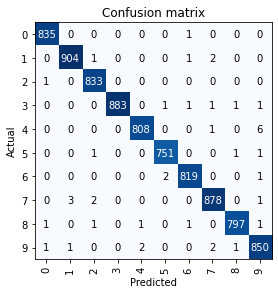

In [71]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

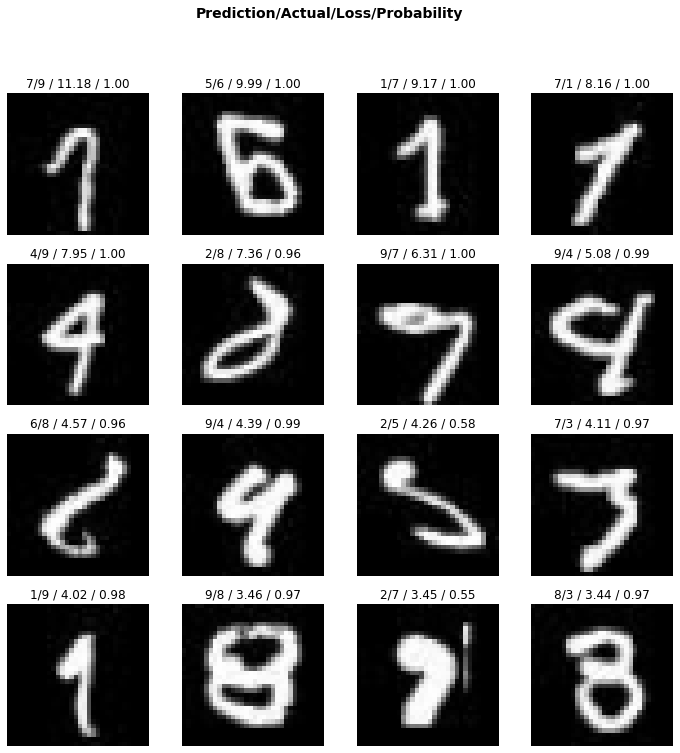

In [75]:
interp.plot_top_losses(16, nrows=4)

In [76]:
test_files = [TEST_IMGS/(str(i)+'.jpg') for i in range(len(test_df))]
len(test_files)

28000

In [77]:
test_dl = learn.dls.test_dl(test_files)
preds, targets, decoded = learn.get_preds(dl=test_dl, with_decoded=True)

In [154]:
# targets is None because this is the test set (we don't know the labels)
print(targets)

None


In [78]:
decoded[:9]

TensorBase([2, 0, 9, 0, 3, 7, 0, 3, 0])

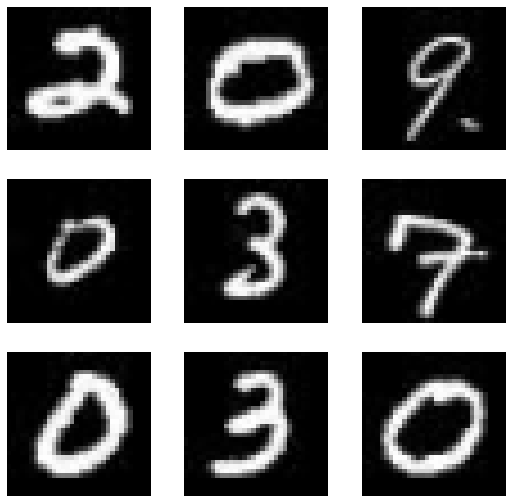

In [79]:
test_dl.show_batch()

Looks good so far!

In [66]:
len(decoded)

28000

In [36]:
PILImage.create(TEST_IMGS/'1.jpg')

In [31]:
# let's manually check a random image from test set
from numpy import random

r=random.randint(len(decoded))
randfn = str(r)+'.jpg'
img = PILImage.create(TEST_IMGS/randfn)
rdecoded, _, rpred = learn.predict(img)
print(randfn, '->',rdecoded)
img

18842.jpg -> 7


In [73]:
import gc
!pip install -qq pynvml
def report_gpu():
    print(torch.cuda.list_gpu_processes())
    gc.collect()
    torch.cuda.empty_cache()

In [80]:
report_gpu()

GPU:0
process      19586 uses     5999.000 MB GPU memory


## Try TTA

In [81]:
valid_dl = learn.dls.valid
valid_preds,valid_targs = learn.get_preds(dl=valid_dl)

In [82]:
error_rate(valid_preds, valid_targs)

TensorBase(0.0050)

In [83]:
tta_preds,_ = learn.tta(dl=valid_dl)
error_rate(tta_preds, valid_targs)

TensorBase(0.0049)

Next, do TTA on that test set:

In [84]:
preds, targets = learn.tta(dl=test_dl)

In [85]:
idxs = preds.argmax(dim=1)
vocab = np.array(learn.dls.vocab)
decoded = pd.Series(vocab[idxs], name="idxs")
decoded

0        2
1        0
2        9
3        0
4        3
        ..
27995    9
27996    7
27997    3
27998    9
27999    2
Name: idxs, Length: 28000, dtype: object

## Prepare submission file

In [87]:
submission = pd.read_csv(path/'sample_submission.csv')

In [88]:
submission.shape

(28000, 2)

In [89]:
submission.Label = decoded
submission[r:r+1]

,ImageId,Label
18842,18843,7


In [90]:
submission

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,0
4,5,3
...,...,...
27995,27996,9
27996,27997,7
27997,27998,3
27998,27999,9


## Submit CSV to Kaggle

In [91]:
# write submission csv
technique = 'convnext_large_in22k finetune 15 epochs with TTA'
sub_filename = Path('subs')/(COMPETITION_NAME+'-'+technique+'-sub.csv')
submission.to_csv(sub_filename, index=False)

if not iskaggle:
    #for sec in tqdm(range(9000)):
    #    time.sleep(1)
    print('about to submit', sub_filename, 'to kaggle')
    ret = kaggle.api.competition_submit(sub_filename, technique, COMPETITION_NAME)
    print(ret)

about to submit subs/digit-recognizer-convnext_large_in22k finetune 15 epochs with TTA-sub.csv to kaggle


100%|██████████| 208k/208k [00:00<00:00, 504kB/s]


Successfully submitted to Digit Recognizer


## Save the best model so far

In [96]:
print(COMPETITION_NAME)

digit-recognizer


In [103]:
learn.export(fname='../../../models/'+(COMPETITION_NAME+'-'+technique)+'.pkl')